**EE219 Winter 2019, Project 2**

In [1]:
# setting the random seed
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

# Import packages

from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

In [3]:
# Define function that generates the 5 measure scores

def scores(ground, clustered, data=None):
    from sklearn.metrics import homogeneity_score
    from sklearn.metrics import completeness_score
    from sklearn.metrics import v_measure_score
    from sklearn.metrics import adjusted_rand_score
    from sklearn.metrics import adjusted_mutual_info_score
    
    if data is not None:
        homogeneity = data['homogeneity']
        completeness = data['completeness']
        v_measure = data['v']
        adjusted_rand_index = data['rand']
        adjusted_mutual_info = data['mutual_info']
    else:
        homogeneity = homogeneity_score(ground, clustered.labels_)
        completeness = completeness_score(ground, clustered.labels_)
        v_measure = v_measure_score(ground, clustered.labels_)
        adjusted_rand_index = adjusted_rand_score(ground, clustered.labels_)
        adjusted_mutual_info = adjusted_mutual_info_score(ground, clustered.labels_)

    print('kmeans clustering results with k=2')
    print('-------------------------------------------------------------------')
    print('Homegeneity: {}'.format(np.round(homogeneity, 4)))
    print('Completeness: {}'.format(np.round(completeness, 4)))
    print('V-measure: {}'.format(np.round(v_measure, 4)))
    print('Adjusted Rand Index: {}'.format(np.round(adjusted_rand_index, 4)))
    print('Adjusted Mutual Information Score: {}'.format(np.round(adjusted_mutual_info, 4)))
    print('-------------------------------------------------------------------')

##### Function for saving pre-fit SVD and NMF scores, and K-Means objects

In [4]:
def load_scores(npz_name):
    import os
    import os.path as path

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    if os.path.isfile('{}/{}.npz'.format(out_dir, npz_name)):
        data = np.load('{}/{}.npz'.format(out_dir, npz_name))
        return data
    else:
        return None
    
def save_scores(npz_name, data):
    import os
    import os.path as path

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    np.savez('{}/{}'.format(out_dir, npz_name), homogeneity=data['homogeneity'], completeness=data['completeness'],
             v=data['v'], rand=data['rand'], mutual_info=data['mutual_info'])
    
def dump_kmeans(model_name, kmeans):
    import os
    import os.path as path
    from joblib import dump, load

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    dump(kmeans, '{}/{}.joblib'.format(out_dir, model_name))
    
def load_kmeans(model_name):
    import os
    import os.path as path
    from joblib import dump, load

    out_dir = 'out'
    
    if not os.path.exists('{}'.format(out_dir)):
        os.mkdir('{}'.format(out_dir))
        
    if os.path.isfile('{}/{}.joblib'.format(out_dir, model_name)):
        return load('{}/{}.joblib'.format(out_dir, model_name))
    else:
        return None

In [5]:
# Set the global directory to place figs in project:
figs_dir = 'figs'

import os
if not os.path.exists(figs_dir):
    os.mkdir(figs_dir)

In [6]:
# Fetching 20NewsGroups dataset

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics', 'comp.sys.mac.hardware', 
              'comp.os.ms-windows.misc', 'rec.autos', 'rec.motorcycles', 
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)


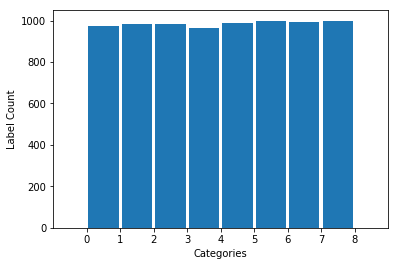

In [7]:
# Fetch all 8 news groups categories and plot a histogram of the training documents.

x = range(-1,23)
plt.hist(twenty_data.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xticks(np.arange(9, step=1))
plt.xlim(left=-1, right = 9)
plt.savefig('{}/8-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

In [8]:
# Change labels into binary based on two well separated classes: Class 1 (labels 0-3) and Class 2 (labels 4-7).
twenty_binary_labels = np.zeros(len(twenty_data.target))
for k in range(len(twenty_data.target)):
    if twenty_data.target[k] >= 4:
        twenty_binary_labels[k] = 1
    else:
        twenty_binary_labels[k] = 0
            
class_names = ['Class 1', 'Class 2']

**Question 1**

In [9]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data = count_vect.fit_transform(twenty_data.data)

In [10]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_data_tfidf = tfidf_transformer.fit_transform(X_data)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf.shape))

Dimensions of the TF-IDF matrix are: (7882, 27768)


**Question 2**

In [11]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans

k_name = 'kmeans_raw8'

kmeans = load_kmeans(k_name)
if kmeans is None:
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1001, n_init = 40).fit(X_data_tfidf)
    dump_kmeans(k_name, kmeans)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator KMeans from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


**Question 2(a)**

In [12]:
# Contingency matrix
def show_contingency(ground_labels, cluster_labels, title='', cmap=plt.cm.Blues,):
    import itertools
    from sklearn.metrics.cluster import contingency_matrix
    cont = contingency_matrix(ground_labels, cluster_labels)
    
    plt.imshow(cont, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cont.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.tight_layout()
    
    thresh = cont.max() / 2.
    for i, j in itertools.product(range(cont.shape[0]), range(cont.shape[1])):
        plt.text(j, i, format(cont[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cont[i, j] > thresh else "black")
        
    plt.show()   

**Question 2(b)**

In [13]:
scores(twenty_binary_labels, kmeans)

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.2536
Completeness: 0.3348
V-measure: 0.2886
Adjusted Rand Index: 0.1808
Adjusted Mutual Information Score: 0.2535
-------------------------------------------------------------------


#### Question 4

In [14]:
# Perform SVD on the TF-IDF matrix
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42)
X_data_svd = svd.fit_transform(X_data_tfidf)

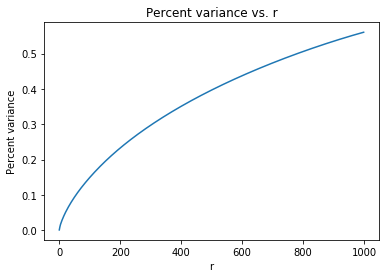

In [15]:
# Plot variance ratios

variances = svd.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(variances))
plt.title('Percent variance vs. r')
plt.xlabel('r')
plt.ylabel('Percent variance')
plt.show()

#### Question 5

In [16]:
# Initialize r, which is basically how many components we want to use.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

In [17]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

In [18]:
# Import packages

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

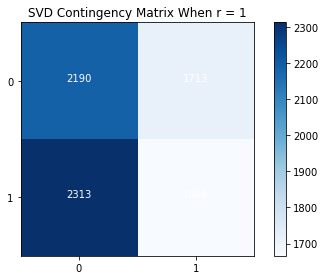

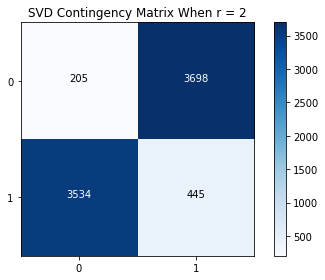

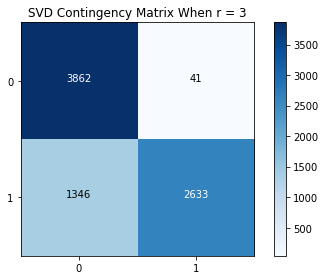

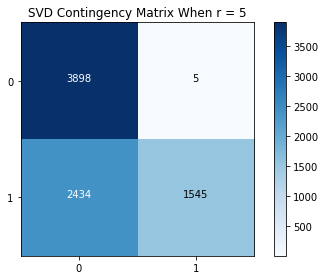

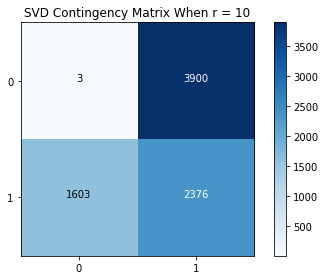

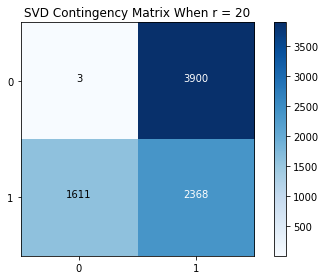

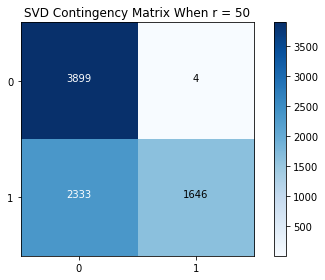

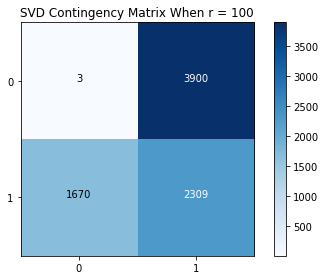

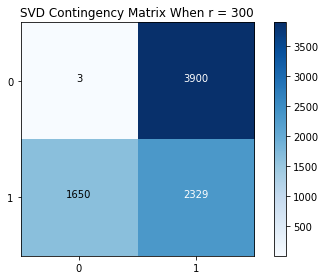

In [19]:
svd_homogeneity = np.zeros(len(r))
svd_completeness = np.zeros(len(r))
svd_v = np.zeros(len(r))
svd_rand = np.zeros(len(r))
svd_mutual_info = np.zeros(len(r))

# svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40)
for i in range(len(r)):
    svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:r[i]].T)
    svd_homogeneity[i] = homogeneity_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_completeness[i] = completeness_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_v[i] = v_measure_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_rand[i] = adjusted_rand_score(twenty_binary_labels, svd_kmeans.labels_)
    title = 'SVD Contingency Matrix When r = ' + str(r[i])
    show_contingency(twenty_binary_labels, svd_kmeans.labels_, title)
    svd_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, svd_kmeans.labels_)
    

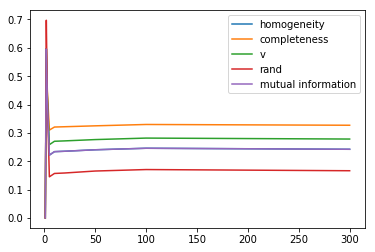

In [20]:
# Plot metrics for svd.

plt.figure()
plt.plot(r, svd_homogeneity)
plt.plot(r, svd_completeness)
plt.plot(r, svd_v)
plt.plot(r, svd_rand)
plt.plot(r, svd_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [21]:
print('Homogeneity scores: ', np.round(svd_homogeneity, 4))
print('Completeness scores: ', np.round(svd_completeness, 4))
print('V measure scores: ', np.round(svd_v, 4))
print('Adjusted rand scores: ', np.round(svd_rand, 4))
print('Adjusted mutual information scores: ', np.round(svd_mutual_info, 4))

Homogeneity scores:  [3.000e-04 5.959e-01 4.164e-01 2.217e-01 2.339e-01 2.353e-01 2.405e-01
 2.459e-01 2.423e-01]
Completeness scores:  [3.000e-04 5.970e-01 4.506e-01 3.100e-01 3.207e-01 3.218e-01 3.249e-01
 3.297e-01 3.270e-01]
V measure scores:  [3.000e-04 5.965e-01 4.329e-01 2.585e-01 2.705e-01 2.718e-01 2.765e-01
 2.817e-01 2.784e-01]
Adjusted rand scores:  [3.000e-04 6.973e-01 4.199e-01 1.452e-01 1.570e-01 1.586e-01 1.656e-01
 1.708e-01 1.666e-01]
Adjusted mutual information scores:  [2.000e-04 5.959e-01 4.164e-01 2.216e-01 2.338e-01 2.353e-01 2.405e-01
 2.458e-01 2.422e-01]


In [22]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [23]:
# Initialize r and each an array for each metric.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

nmf_homogeneity = np.zeros(len(r))
nmf_completeness = np.zeros(len(r))
nmf_v = np.zeros(len(r))
nmf_rand = np.zeros(len(r))
nmf_mutual_info = np.zeros(len(r))

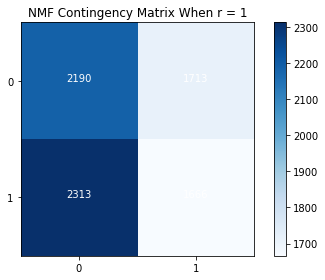

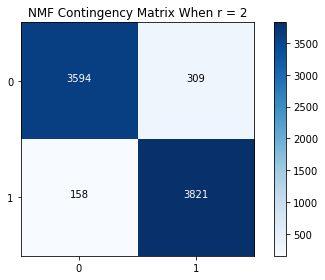

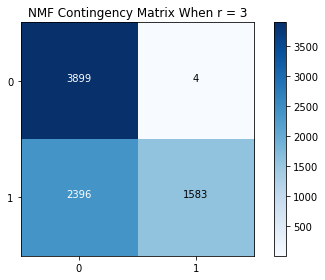

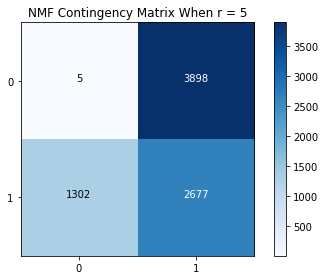

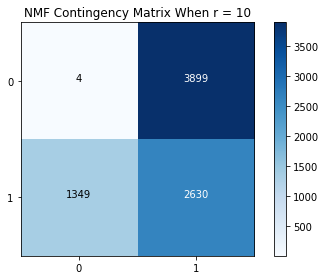

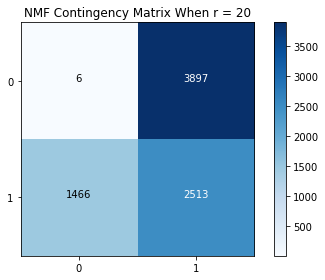

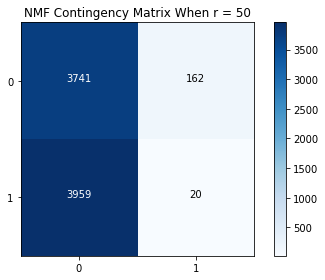

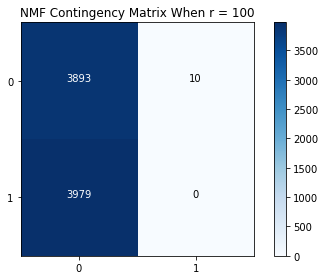

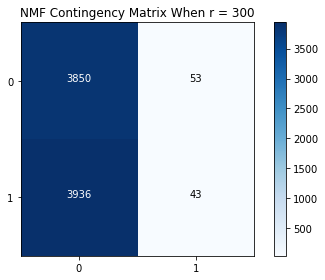

In [24]:
# Perform NMF for each number of components and calculate each metric

for i in range(len(r)):
    nmf = NMF(n_components=r[i])
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf)
    nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)
    nmf_homogeneity[i] = homogeneity_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_completeness[i] = completeness_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_v[i] = v_measure_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_rand[i] = adjusted_rand_score(twenty_binary_labels, nmf_kmeans.labels_)
    title = 'NMF Contingency Matrix When r = ' + str(r[i])
    show_contingency(twenty_binary_labels, nmf_kmeans.labels_, title)
    nmf_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, nmf_kmeans.labels_)

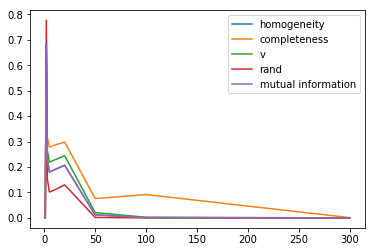

In [25]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r, nmf_homogeneity)
plt.plot(r, nmf_completeness)
plt.plot(r, nmf_v)
plt.plot(r, nmf_rand)
plt.plot(r, nmf_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [26]:
print('Homogeneity scores: ', np.round(nmf_homogeneity, 4))
print('Completeness scores: ', np.round(nmf_completeness, 4))
print('V measure scores: ', np.round(nmf_v, 4))
print('Adjusted rand scores: ', np.round(nmf_rand, 4))
print('Adjusted mutual information scores: ', np.round(nmf_mutual_info, 4))

Homogeneity scores:  [3.000e-04 6.790e-01 2.293e-01 1.806e-01 1.893e-01 2.071e-01 1.210e-02
 1.300e-03 1.000e-04]
Completeness scores:  [3.000e-04 6.801e-01 3.165e-01 2.787e-01 2.862e-01 2.982e-01 7.610e-02
 9.170e-02 1.200e-03]
V measure scores:  [3.000e-04 6.796e-01 2.660e-01 2.192e-01 2.279e-01 2.444e-01 2.080e-02
 2.500e-03 2.000e-04]
Adjusted rand scores:  [3.000e-04 7.770e-01 1.528e-01 1.020e-01 1.099e-01 1.301e-01 2.000e-03
 1.000e-04 1.000e-04]
Adjusted mutual information scores:  [2.000e-04 6.790e-01 2.293e-01 1.806e-01 1.893e-01 2.071e-01 1.200e-02
 1.200e-03 0.000e+00]


#### Question 6

Both the SVD and NMF measures have non-monotonic behaviors as r increases. There is a spike in all measures at a particular r, and then the measures begin to diverge from eachother. The rand, mutual information, and homogeneity scores are closer to zero after the spike. The homogeneity score very closely follows the mutual information score. The sudden drop in r suggests that K-Means is greatly negatively affected. Since K-Means relies on the centroid of the dataset to be stable and representative of each class, it is straightforward to think that the additions of outliers will create a centroid that is no longer entirely representative of the class. There is a peak score because the dimensions kept in the dimensions reduction are the dimensions in which the outliers of the dataset aren't as large. This is due to the fact that the dimensionality reduction is attempting to find the closest representation to the original dataset. Clearly, it will minimize the variance that the outliers create in the dataset by choosing the most prominent dimensions to be those which have the least outlier variance. Hence, there is a point in which the variance will begin to greatly affect K-Means. This corresponds to the peak shown in the figures. This is not the only function that the dimension reduction is attempting to reduce, which is why the scores are not monotonically decreasing - sometimes the variance of the outliers plays a large role, but other times the variance of the majority of the points plays a larger role.

#### Question 7

Visualize the clustering results for SVD with best r and NMF with best r

In [70]:
# Visualize clustering results on 2-D plane with SVD and coloring
# Compare ground truth label and clustering label plots

# Define what the best r is for both SVD and NMF
SVD_best_r = 2
NMF_best_r = 2

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)

In [71]:
# Define function that visualizes the results

def visualize(label, axes, title, flip = 1):
    
    # If color needs to be fliped, set flip = 0
    
    if np.array_equal(label, twenty_binary_labels):
        label_for_color = twenty_binary_labels
    else:
        label_for_color = label.labels_
    
    color_for_plotting = np.zeros(len(label_for_color))

    for i in range(len(label_for_color)):
        if label_for_color[i] == flip:
            color_for_plotting[i] = 1
            
    mean0 = np.mean(axes[label_for_color == 0], axis=0)
    mean1 = np.mean(axes[label_for_color != 0], axis=0)
    plt.scatter(axes[:,0] ,axes[:,1], c = color_for_plotting)
    plt.plot(mean0[0], mean0[1], 'x', color='black', mew=3, ms=16)
    plt.plot(mean0[0], mean0[1], 'x', color='white', mew=2, ms=15)
    plt.plot(mean1[0], mean1[1], 'x', color='black', mew=3, ms=16)
    plt.plot(mean1[0], mean1[1], 'x', color='white', mew=2, ms=15)
    plt.title(title)
    plt.show()

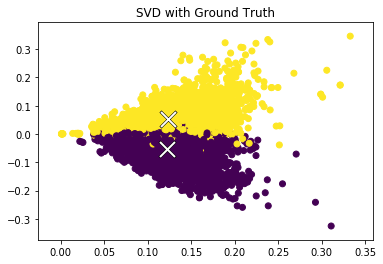

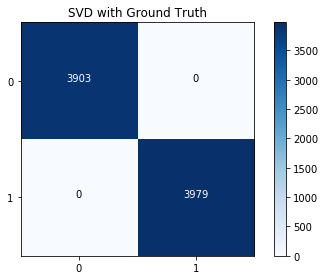

In [72]:
# SVD, ground truth

data_svd_to_plot = X_data_svd_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(twenty_binary_labels, data_svd_to_plot, 'SVD with Ground Truth', 0)

show_contingency(twenty_binary_labels, twenty_binary_labels, 'SVD with Ground Truth')

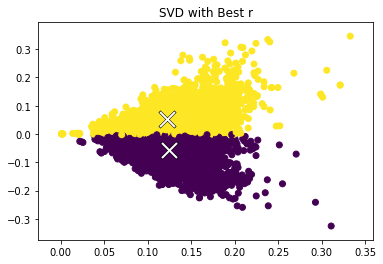

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6062
Completeness: 0.6066
V-measure: 0.6064
Adjusted Rand Index: 0.7105
Adjusted Mutual Information Score: 0.6062
-------------------------------------------------------------------


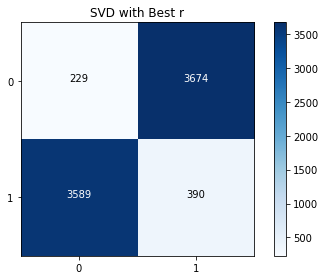

In [73]:
# SVD with best r

svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:SVD_best_r].T)
data_svd_to_plot = X_data_svd_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(svd_kmeans, data_svd_to_plot, 'SVD with Best r',1)

scores(twenty_binary_labels, svd_kmeans)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Best r')

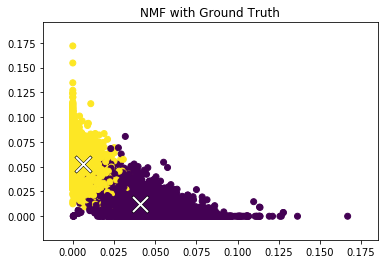

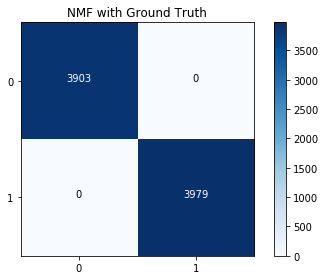

In [74]:
# NMF, ground truth

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

data_nmf_to_plot = X_data_nmf_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(twenty_binary_labels, data_nmf_to_plot, 'NMF with Ground Truth')

show_contingency(twenty_binary_labels, twenty_binary_labels, 'NMF with Ground Truth')

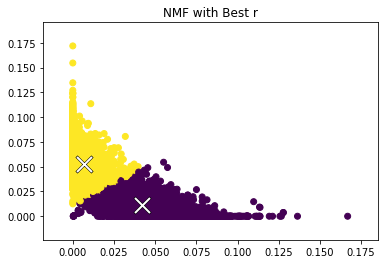

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.679
Completeness: 0.6801
V-measure: 0.6796
Adjusted Rand Index: 0.777
Adjusted Mutual Information Score: 0.679
-------------------------------------------------------------------


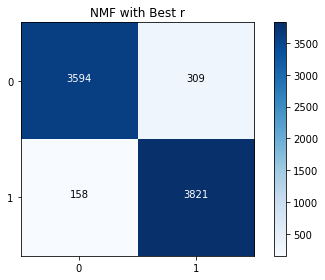

In [75]:
# NMF with best r

# Reset NMF

nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    
nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)

data_nmf_to_plot = X_data_nmf_r[:, 0:2] # Take the first two columns of the svd Data to plot

visualize(nmf_kmeans, data_nmf_to_plot, 'NMF with Best r',1)

scores(twenty_binary_labels, nmf_kmeans)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Best r')

#### Question 8

Transforming the data

In [76]:
# Scaling features such that each feature has unit variance

def scaling (features): # Each column of the reduced dimension data has unit variance 
    return (features - np.mean(features,axis=0)) / np.std(features, axis=0)    

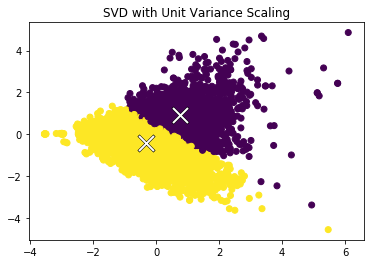

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.2352
Completeness: 0.2635
V-measure: 0.2485
Adjusted Rand Index: 0.2546
Adjusted Mutual Information Score: 0.2351
-------------------------------------------------------------------


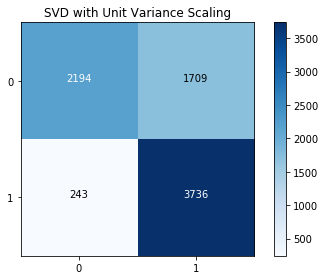

In [77]:
# SVD with Unit Variance Transform

svd_uv_transform = scaling(X_data_svd_r)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_uv_transform.T[0:SVD_best_r].T)

visualize(svd_kmeans, svd_uv_transform, 'SVD with Unit Variance Scaling',1)
scores(twenty_binary_labels, svd_kmeans)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Unit Variance Scaling')

In [78]:
# Logarithm transformation 

def logarithm_trans (features): 
    
    c_const = 0.01
    return np.sign(features) * (np.log(np.abs(features) + c_const) - np.log(c_const))

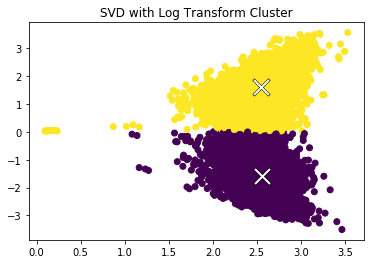

In [88]:
# SVD with Logarithm Transform

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_log_transform = logarithm_trans(X_data_svd_r)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_log_transform[:, 0:SVD_best_r])

visualize(svd_kmeans, svd_log_transform, 'SVD with Log Transform Cluster',0)

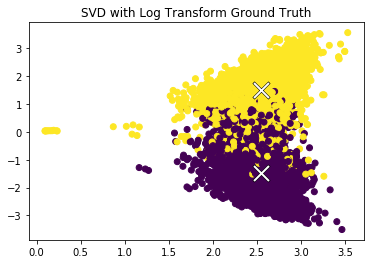

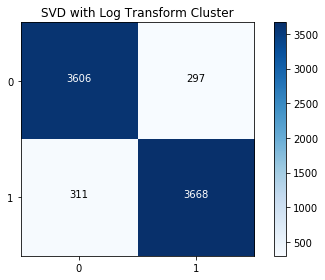

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.608
Completeness: 0.608
V-measure: 0.608
Adjusted Rand Index: 0.7152
Adjusted Mutual Information Score: 0.608
-------------------------------------------------------------------


In [89]:
visualize(twenty_binary_labels, svd_log_transform, 'SVD with Log Transform Ground Truth', 0)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Log Transform Cluster')

scores(twenty_binary_labels, svd_kmeans)

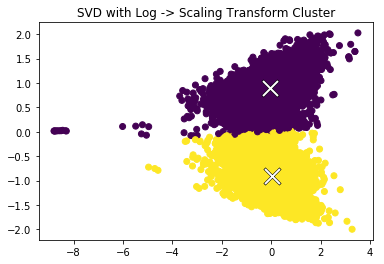

In [81]:
# SVD with Logarithm -> Scaling Transform

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_log_transform = logarithm_trans(X_data_svd_r)

svd_log_scaling_transform = scaling(svd_log_transform)
svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(svd_log_scaling_transform[:, 0:SVD_best_r])

visualize(svd_kmeans, svd_log_scaling_transform, 'SVD with Log -> Scaling Transform Cluster', 1)

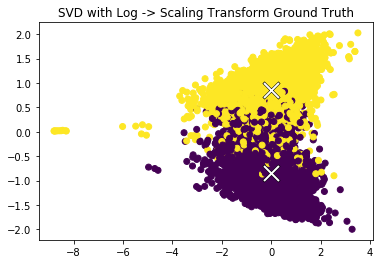

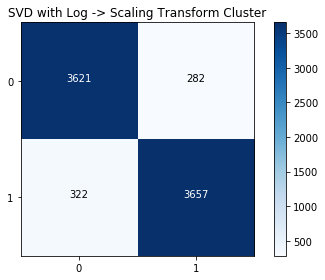

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.61
Completeness: 0.61
V-measure: 0.61
Adjusted Rand Index: 0.7169
Adjusted Mutual Information Score: 0.61
-------------------------------------------------------------------


In [82]:
visualize(twenty_binary_labels, svd_log_scaling_transform, 'SVD with Log -> Scaling Transform Ground Truth', 0)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Log -> Scaling Transform Cluster')

scores(twenty_binary_labels, svd_kmeans)

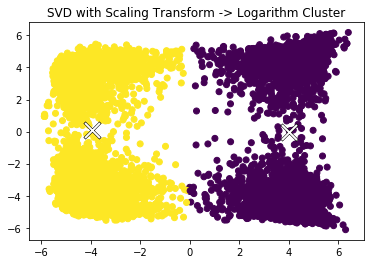

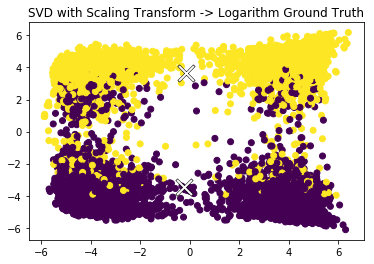

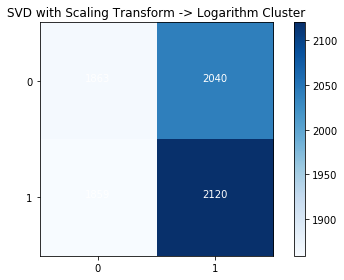

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.0001
Completeness: 0.0001
V-measure: 0.0001
Adjusted Rand Index: -0.0
Adjusted Mutual Information Score: -0.0
-------------------------------------------------------------------


In [83]:
# SVD with Scaling Transform -> Logarithm

svd = TruncatedSVD(n_components=SVD_best_r)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

svd_scaling_transform = scaling(X_data_svd_r)

svd_scaling_log_transform = logarithm_trans(svd_scaling_transform)
svd_kmeans = KMeans(n_clusters=2, random_state=100, max_iter=2000, n_init=200).fit(svd_scaling_log_transform[:, 0:SVD_best_r])

visualize(svd_kmeans, svd_scaling_log_transform, 'SVD with Scaling Transform -> Logarithm Cluster')
visualize(twenty_binary_labels, svd_scaling_log_transform, 'SVD with Scaling Transform -> Logarithm Ground Truth',0)

show_contingency(twenty_binary_labels, svd_kmeans.labels_, 'SVD with Scaling Transform -> Logarithm Cluster')

scores(twenty_binary_labels, svd_kmeans)

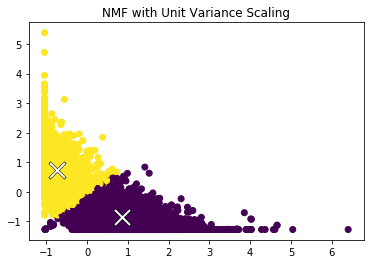

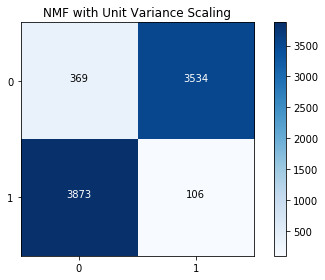

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6828
Completeness: 0.6856
V-measure: 0.6842
Adjusted Rand Index: 0.7734
Adjusted Mutual Information Score: 0.6828
-------------------------------------------------------------------


In [84]:
# NMF with Unit Variance Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_uv_transform = scaling(X_data_nmf_r)
nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_uv_transform)

visualize(nmf_kmeans, nmf_uv_transform, 'NMF with Unit Variance Scaling', 0)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Unit Variance Scaling')

scores(twenty_binary_labels, nmf_kmeans)

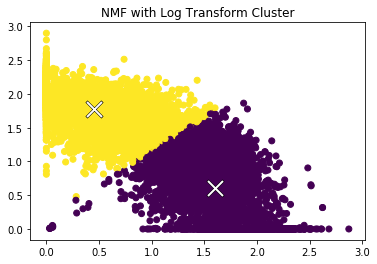

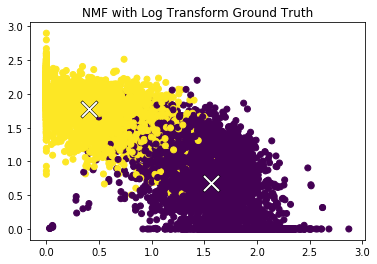

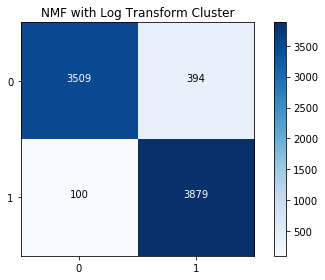

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6757
Completeness: 0.6791
V-measure: 0.6774
Adjusted Rand Index: 0.765
Adjusted Mutual Information Score: 0.6757
-------------------------------------------------------------------


In [85]:
# NMF with Logarithm Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_log_transform = logarithm_trans(X_data_nmf_r)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_log_transform)

visualize(nmf_kmeans, nmf_log_transform, 'NMF with Log Transform Cluster', 1)
visualize(twenty_binary_labels, nmf_log_transform, 'NMF with Log Transform Ground Truth', 1)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Log Transform Cluster')

scores(twenty_binary_labels, nmf_kmeans)

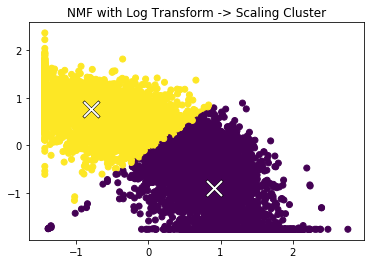

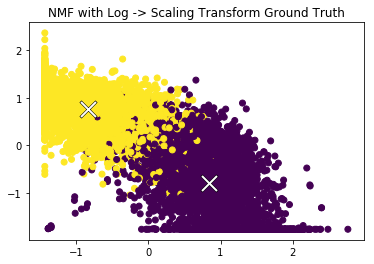

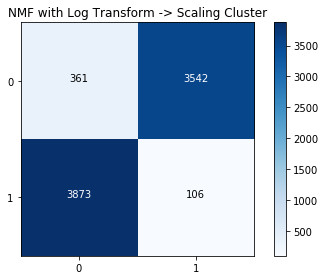

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.6864
Completeness: 0.6891
V-measure: 0.6877
Adjusted Rand Index: 0.777
Adjusted Mutual Information Score: 0.6863
-------------------------------------------------------------------


In [86]:
# NMF with Logarithm -> Scaling Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_log_transform = logarithm_trans(X_data_nmf_r)
nmf_log_scaling_transform = scaling(nmf_log_transform)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_log_scaling_transform)

visualize(nmf_kmeans, nmf_log_scaling_transform, 'NMF with Log Transform -> Scaling Cluster', 0)
visualize(twenty_binary_labels, nmf_log_scaling_transform, 'NMF with Log -> Scaling Transform Ground Truth', 1)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Log Transform -> Scaling Cluster')

scores(twenty_binary_labels, nmf_kmeans)

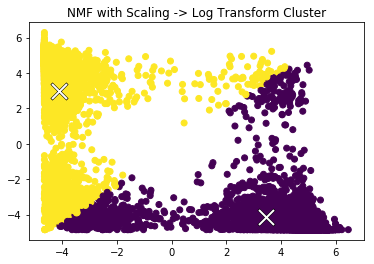

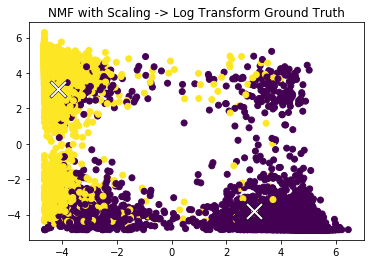

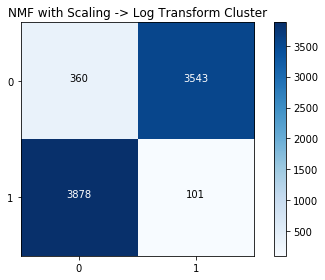

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.69
Completeness: 0.6928
V-measure: 0.6914
Adjusted Rand Index: 0.7797
Adjusted Mutual Information Score: 0.6899
-------------------------------------------------------------------


In [87]:
# NMF with Scaling -> Logarithm Transform

# Reset NMF
nmf = NMF(n_components=NMF_best_r)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf)    

nmf_scaling_transform = scaling(X_data_nmf_r)

nmf_scaling_log_transform = logarithm_trans(nmf_scaling_transform)

nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(nmf_scaling_log_transform)

visualize(nmf_kmeans, nmf_scaling_log_transform, 'NMF with Scaling -> Log Transform Cluster', 0)
visualize(twenty_binary_labels, nmf_scaling_log_transform, 'NMF with Scaling -> Log Transform Ground Truth', 1)

show_contingency(twenty_binary_labels, nmf_kmeans.labels_, 'NMF with Scaling -> Log Transform Cluster')

scores(twenty_binary_labels, nmf_kmeans)

#### Question 11

##### Pull in the 20-category dataset

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\axes\_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\axes\_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


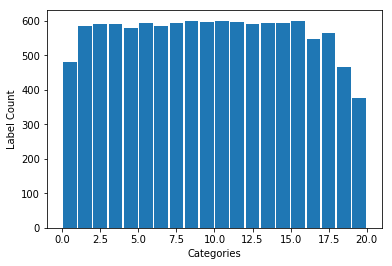

20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [15]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

twenty_data20 = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
x = range(-1,23)
plt.hist(twenty_data20.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xlim(xmin=-1, xmax = 21)
plt.savefig('{}/20-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

category_labels = twenty_data20.target
categories = twenty_data20.target_names
print(len(categories)) # there should be 20
print(categories)

##### Redo CountVect and TF-IDF calculations

In [16]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect20 = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data20 = count_vect20.fit_transform(twenty_data20.data)

In [17]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer20 = TfidfTransformer()

# do for training
X_data_tfidf20 = tfidf_transformer20.fit_transform(X_data20)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf20.shape))

Dimensions of the TF-IDF matrix are: (11314, 38563)


##### Applying K-means

In [18]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans
import time

k_name20 = 'kmeans_raw20'

kmeans20 = load_kmeans(k_name20)
start_time = time.time()
if kmeans20 is None:
    # reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init = 40, n_jobs=-1).fit(X_data_tfidf20)
    dump_kmeans(k_name20, kmeans20)
print('Time taken for kmean 20-class clustering: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class clustering: 0.00 minutes


#### Report the 5 measures:

In [19]:
scores(category_labels, kmeans20)

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3086
Completeness: 0.3911
V-measure: 0.345
Adjusted Rand Index: 0.1105
Adjusted Mutual Information Score: 0.3048
-------------------------------------------------------------------


##### and the contingency matrix:

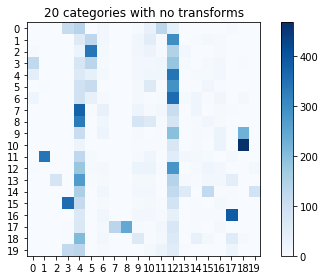

In [20]:
# Contingency matrix
show_contingency(category_labels, kmeans20.labels_, title='20 categories with no transforms')

#### Question 12

##### Analyzing SVD:

In [21]:
# Initialize r, which is basically how many components we want to use.
r20 = [1, 2, 3, 5, 10, 20, 50, 100, 300, 1000]

def show_best(model_type, scores):
    best = r20[np.argmax(scores)]
    print('best {}:'.format(model_type), best)
    return best

In [22]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd20 = TruncatedSVD(n_components=r20[-1])
X_data_svd_r20 = svd20.fit_transform(X_data_tfidf20)

In [23]:
import time
start_time = time.time()

npz_name = 'svd20'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_svd_r20[:, 0:r20[i]])
        svd_homogeneity[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity,
        'completeness': svd_completeness,
        'v': svd_v,
        'rand': svd_rand,
        'mutual_info': svd_mutual_info
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity = data['homogeneity']
    svd_completeness = data['completeness']
    svd_v = data['v']
    svd_rand = data['rand']
    svd_mutual_info = data['mutual_info']
    
print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class SVD search: 0.00 minutes


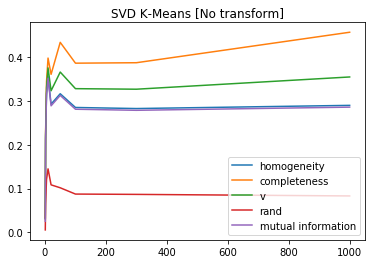

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0308 0.2142 0.2494 0.3168 0.3551 0.2926 0.3161 0.2848 0.2824 0.2897]
Completeness: [0.0345 0.2313 0.2627 0.3436 0.3974 0.3604 0.4333 0.3858 0.3868 0.4563]
V-measure: [0.0325 0.2224 0.2559 0.3296 0.3751 0.323  0.3656 0.3277 0.3265 0.3544]
Adjusted Rand Index: [0.0058 0.0651 0.0835 0.1205 0.1449 0.1085 0.1018 0.0875 0.0868 0.0832]
Adjusted Mutual Information Score: [0.0255 0.2099 0.2454 0.3131 0.3516 0.2887 0.3123 0.2809 0.2784 0.2856]
-------------------------------------------------------------------


In [24]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity)
plt.plot(r20, svd_completeness)
plt.plot(r20, svd_v)
plt.plot(r20, svd_rand)
plt.plot(r20, svd_mutual_info)

plt.title('SVD K-Means [No transform]')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

##### Analyzing NMF:

In [100]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [101]:
# Perform NMF for each number of components and calculate each metric

nmf_homogeneity = np.zeros(len(r20))
nmf_completeness = np.zeros(len(r20))
nmf_v = np.zeros(len(r20))
nmf_rand = np.zeros(len(r20))
nmf_mutual_info = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r = nmf.fit_transform(X_data_tfidf20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_nmf_r)
        nmf_homogeneity[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity,
        'completeness': nmf_completeness,
        'v': nmf_v,
        'rand': nmf_rand,
        'mutual_info': nmf_mutual_info
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity = data['homogeneity']
    nmf_completeness = data['completeness']
    nmf_v = data['v']
    nmf_rand = data['rand']
    nmf_mutual_info = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class NMF search: 0.00 minutes


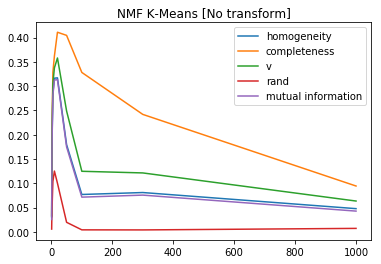

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0308 0.1702 0.2169 0.2854 0.3163 0.317  0.1795 0.077  0.081  0.0478]
Completeness: [0.0345 0.1816 0.2471 0.3284 0.362  0.4109 0.4044 0.3281 0.2418 0.0944]
V-measure: [0.0325 0.1757 0.231  0.3054 0.3376 0.3579 0.2487 0.1247 0.1214 0.0635]
Adjusted Rand Index: [0.0058 0.0493 0.0634 0.1039 0.1252 0.1002 0.0197 0.0042 0.0041 0.0072]
Adjusted Mutual Information Score: [0.0255 0.1656 0.2127 0.2814 0.3125 0.3132 0.1749 0.0715 0.0757 0.0428]
-------------------------------------------------------------------


In [102]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity)
plt.plot(r20, nmf_completeness)
plt.plot(r20, nmf_v)
plt.plot(r20, nmf_rand)
plt.plot(r20, nmf_mutual_info)

plt.title('NMF K-Means [No transform]')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

##### Choosing best r for SVD and NMF

In [139]:
# svd_r20_best = r20[np.argmax(svd_rand)]
# print('best r20 svd:', svd_r20_best)
# nmf_r20_best = r20[np.argmax(nmf_rand)]
# print('best r20 nmf:', nmf_r20_best)
best_r_svd = show_best('svd', svd_rand)
best_r_nmf = show_best('nmf', nmf_rand)

best svd: 10
best nmf: 10


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3551
Completeness: 0.3974
V-measure: 0.3751
Adjusted Rand Index: 0.1449
Adjusted Mutual Information Score: 0.3516
-------------------------------------------------------------------


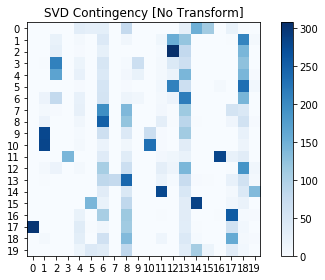

In [140]:
svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_svd_r20[:, 0:best_r_svd])

scores(category_labels, svd_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='SVD Contingency [No Transform]')

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3043
Completeness: 0.3463
V-measure: 0.3239
Adjusted Rand Index: 0.1175
Adjusted Mutual Information Score: 0.3005
-------------------------------------------------------------------


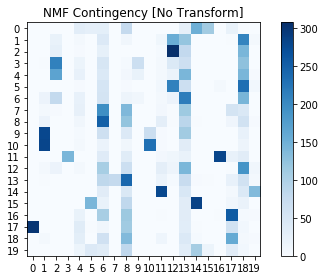

In [141]:
nmf = NMF(n_components=best_r_nmf)
X_data_nmf_r = nmf.fit_transform(X_data_tfidf20)
nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(X_data_nmf_r)

scores(category_labels, nmf_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='NMF Contingency [No Transform]')

##### Perform Scaling Transform and attain new graphs

In [65]:
# Perform SVD

svd_uv_transform20 = scaling(X_data_svd_r20)

svd_homogeneity_uv = np.zeros(len(r20))
svd_completeness_uv = np.zeros(len(r20))
svd_v_uv = np.zeros(len(r20))
svd_rand_uv = np.zeros(len(r20))
svd_mutual_info_uv = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_transform20[:, 0:r20[i]])
        svd_homogeneity_uv[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_uv[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_uv[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_uv[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_uv[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_uv,
        'completeness': svd_completeness_uv,
        'v': svd_v_uv,
        'rand': svd_rand_uv,
        'mutual_info': svd_mutual_info_uv
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_uv = data['homogeneity']
    svd_completeness_uv = data['completeness']
    svd_v_uv = data['v']
    svd_rand_uv = data['rand']
    svd_mutual_info_uv = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class SVD search: 0.00 minutes


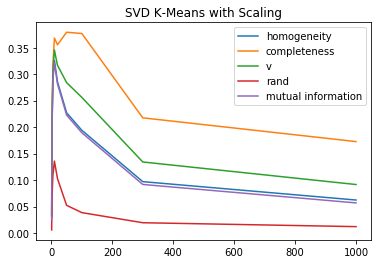

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0308 0.1993 0.2279 0.2937 0.3255 0.2858 0.2271 0.194  0.097  0.0623]
Completeness: [0.0345 0.2126 0.2421 0.3171 0.3683 0.3554 0.3792 0.3768 0.2175 0.1727]
V-measure: [0.0325 0.2057 0.2348 0.3049 0.3456 0.3168 0.2841 0.2561 0.1341 0.0915]
Adjusted Rand Index: [0.0058 0.0599 0.0788 0.1085 0.1358 0.1029 0.0522 0.0385 0.0194 0.012 ]
Adjusted Mutual Information Score: [0.0255 0.1949 0.2237 0.2898 0.3218 0.2819 0.2228 0.1894 0.0917 0.0568]
-------------------------------------------------------------------


In [66]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_uv)
plt.plot(r20, svd_completeness_uv)
plt.plot(r20, svd_v_uv)
plt.plot(r20, svd_rand_uv)
plt.plot(r20, svd_mutual_info_uv)

plt.title('SVD K-Means with Scaling')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [67]:
# Perform NMF

nmf_homogeneity_uv = np.zeros(len(r20))
nmf_completeness_uv = np.zeros(len(r20))
nmf_v_uv = np.zeros(len(r20))
nmf_rand_uv = np.zeros(len(r20))
nmf_mutual_info_uv = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_uv_transform20 = scaling(X_data_nmf_r20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_transform20)
        nmf_homogeneity_uv[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_uv[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_uv[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_uv[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_uv[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_uv,
        'completeness': nmf_completeness_uv,
        'v': nmf_v_uv,
        'rand': nmf_rand_uv,
        'mutual_info': nmf_mutual_info_uv
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_uv = data['homogeneity']
    nmf_completeness_uv = data['completeness']
    nmf_v_uv = data['v']
    nmf_rand_uv = data['rand']
    nmf_mutual_info_uv = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class NMF search: 0.00 minutes


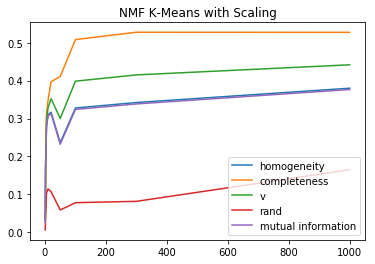

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0308 0.1651 0.2106 0.2824 0.3102 0.3166 0.2363 0.3278 0.3422 0.3801]
Completeness: [0.0345 0.1773 0.2336 0.313  0.3483 0.397  0.4111 0.5085 0.5278 0.5276]
V-measure: [0.0325 0.171  0.2215 0.2969 0.3282 0.3523 0.3001 0.3986 0.4152 0.4418]
Adjusted Rand Index: [0.0058 0.0461 0.058  0.1033 0.1141 0.1068 0.0584 0.0777 0.0813 0.1647]
Adjusted Mutual Information Score: [0.0255 0.1605 0.2063 0.2784 0.3065 0.3128 0.232  0.324  0.3385 0.3766]
-------------------------------------------------------------------


In [68]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_uv)
plt.plot(r20, nmf_completeness_uv)
plt.plot(r20, nmf_v_uv)
plt.plot(r20, nmf_rand_uv)
plt.plot(r20, nmf_mutual_info_uv)

plt.title('NMF K-Means with Scaling')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [69]:
# svd_uv_r20_best = r20[np.argmax(svd_rand_uv)]
# print('best r20 svd:', svd_uv_r20_best)
# nmf_uv_r20_best = r20[np.argmax(nmf_rand_uv)]
# print('best r20 nmf:', nmf_uv_r20_best)
best_r_svd_uv = show_best('svd uv', svd_rand_uv)
best_r_nmf_uv = show_best('nmf uv', nmf_rand_uv[:-1])

best svd uv: 10
best nmf uv: 10


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3255
Completeness: 0.3683
V-measure: 0.3456
Adjusted Rand Index: 0.1358
Adjusted Mutual Information Score: 0.3218
-------------------------------------------------------------------


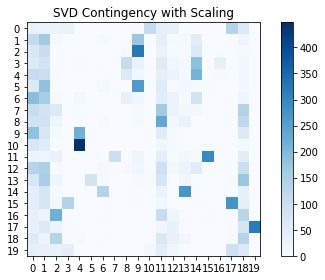

In [70]:
svd_uv_transform20 = scaling(X_data_svd_r20)
svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_transform20[:, 0:best_r_svd_uv])

scores(category_labels, svd_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='SVD Contingency with Scaling')

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3103
Completeness: 0.3483
V-measure: 0.3282
Adjusted Rand Index: 0.1142
Adjusted Mutual Information Score: 0.3065
-------------------------------------------------------------------


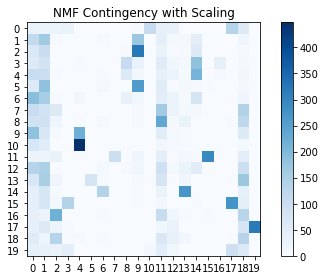

In [71]:
nmf = NMF(n_components=best_r_nmf_uv)
X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
nmf_uv_transform20 = scaling(X_data_nmf_r20)
nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_transform20)

scores(category_labels, nmf_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='NMF Contingency with Scaling')

##### Perform Log Transform and attain new graphs

In [72]:
# Perform SVD

svd_log_transform20 = logarithm_trans(X_data_svd_r20)

svd_homogeneity_log = np.zeros(len(r20))
svd_completeness_log = np.zeros(len(r20))
svd_v_log = np.zeros(len(r20))
svd_rand_log = np.zeros(len(r20))
svd_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_transform20[:, 0:r20[i]])
        svd_homogeneity_log[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_log[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_log[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_log[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_log,
        'completeness': svd_completeness_log,
        'v': svd_v_log,
        'rand': svd_rand_log,
        'mutual_info': svd_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_log = data['homogeneity']
    svd_completeness_log = data['completeness']
    svd_v_log = data['v']
    svd_rand_log = data['rand']
    svd_mutual_info_log = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class SVD search: 0.00 minutes


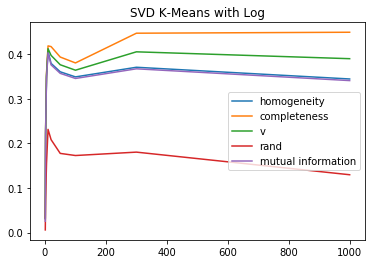

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0306 0.2215 0.2687 0.3491 0.4061 0.3793 0.3604 0.349  0.3706 0.3443]
Completeness: [0.0337 0.2292 0.2735 0.3579 0.4185 0.4169 0.3935 0.3803 0.4469 0.4491]
V-measure: [0.0321 0.2253 0.2711 0.3535 0.4122 0.3972 0.3762 0.364  0.4052 0.3898]
Adjusted Rand Index: [0.0059 0.0734 0.102  0.1547 0.2313 0.2082 0.1774 0.1727 0.1803 0.1296]
Adjusted Mutual Information Score: [0.0253 0.2172 0.2647 0.3456 0.4029 0.3759 0.3569 0.3455 0.3671 0.3407]
-------------------------------------------------------------------


In [73]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_log)
plt.plot(r20, svd_completeness_log)
plt.plot(r20, svd_v_log)
plt.plot(r20, svd_rand_log)
plt.plot(r20, svd_mutual_info_log)

plt.title('SVD K-Means with Log')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [74]:
# Perform NMF

nmf_homogeneity_log = np.zeros(len(r20))
nmf_completeness_log = np.zeros(len(r20))
nmf_v_log = np.zeros(len(r20))
nmf_rand_log = np.zeros(len(r20))
nmf_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_transform20)
        nmf_homogeneity_log[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_log[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_log[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_log[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_log,
        'completeness': nmf_completeness_log,
        'v': nmf_v_log,
        'rand': nmf_rand_log,
        'mutual_info': nmf_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_log = data['homogeneity']
    nmf_completeness_log = data['completeness']
    nmf_v_log = data['v']
    nmf_rand_log = data['rand']
    nmf_mutual_info_log = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class NMF search: 0.00 minutes


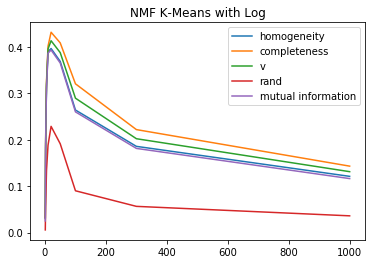

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0303 0.1788 0.2402 0.3147 0.39   0.3967 0.3689 0.2641 0.1858 0.1211]
Completeness: [0.0334 0.1848 0.2535 0.3271 0.4018 0.4318 0.4089 0.3206 0.2219 0.1431]
V-measure: [0.0318 0.1818 0.2466 0.3208 0.3958 0.4135 0.3879 0.2896 0.2022 0.1312]
Adjusted Rand Index: [0.0056 0.0558 0.0802 0.1342 0.1883 0.2289 0.1914 0.09   0.0564 0.036 ]
Adjusted Mutual Information Score: [0.0249 0.1744 0.236  0.311  0.3867 0.3935 0.3655 0.2601 0.1813 0.1163]
-------------------------------------------------------------------


In [75]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_log)
plt.plot(r20, nmf_completeness_log)
plt.plot(r20, nmf_v_log)
plt.plot(r20, nmf_rand_log)
plt.plot(r20, nmf_mutual_info_log)

plt.title('NMF K-Means with Log')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

#### Choose best r for transformation

In [76]:
svd_log_r20_best = r20[np.argmax(svd_rand_log)]
print('best r20 svd:', svd_log_r20_best)
nmf_log_r20_best = r20[np.argmax(nmf_rand_log)]
print('best r20 nmf:', nmf_log_r20_best)

best r20 svd: 10
best r20 nmf: 20


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.4061
Completeness: 0.4185
V-measure: 0.4122
Adjusted Rand Index: 0.2313
Adjusted Mutual Information Score: 0.4029
-------------------------------------------------------------------


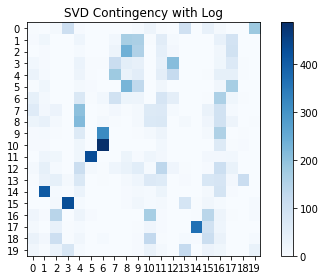

In [77]:
svd_log_transform20 = logarithm_trans(X_data_svd_r20)
svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_transform20[:, 0:svd_log_r20_best])

scores(category_labels, svd_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='SVD Contingency with Log')

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3965
Completeness: 0.4244
V-measure: 0.41
Adjusted Rand Index: 0.2327
Adjusted Mutual Information Score: 0.3932
-------------------------------------------------------------------


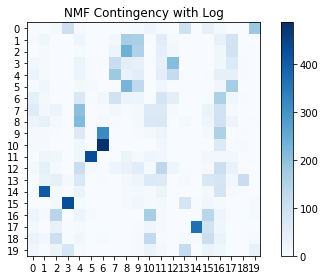

In [78]:
nmf = NMF(n_components=nmf_log_r20_best)
X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_transform20)

scores(category_labels, nmf_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='NMF Contingency with Log')

##### Perform  Log -> Scaling Transform and attain new graphs

In [89]:
# Perform SVD

svd_log_transform20 = logarithm_trans(X_data_svd_r20)
svd_log_scaling_transform20 = scaling(svd_log_transform20)

svd_homogeneity_log = np.zeros(len(r20))
svd_completeness_log = np.zeros(len(r20))
svd_v_log = np.zeros(len(r20))
svd_rand_log = np.zeros(len(r20))
svd_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_log_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_scaling_transform20[:, 0:r20[i]])
        svd_homogeneity_log[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_log[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_log[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_log[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_log,
        'completeness': svd_completeness_log,
        'v': svd_v_log,
        'rand': svd_rand_log,
        'mutual_info': svd_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_log = data['homogeneity']
    svd_completeness_log = data['completeness']
    svd_v_log = data['v']
    svd_rand_log = data['rand']
    svd_mutual_info_log = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class SVD search: 0.00 minutes


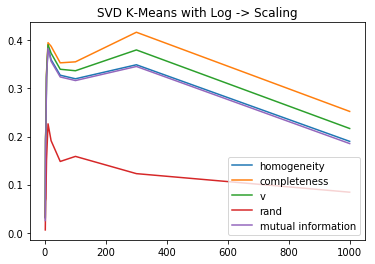

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0306 0.1959 0.2073 0.3241 0.3866 0.3598 0.3274 0.32   0.3491 0.1899]
Completeness: [0.0337 0.2054 0.2149 0.3338 0.395  0.3877 0.3531 0.3552 0.4167 0.2521]
V-measure: [0.0321 0.2006 0.211  0.3289 0.3908 0.3732 0.3398 0.3367 0.3799 0.2166]
Adjusted Rand Index: [0.0059 0.0656 0.0705 0.1509 0.2264 0.1914 0.1481 0.1587 0.1228 0.0843]
Adjusted Mutual Information Score: [0.0253 0.1916 0.203  0.3204 0.3833 0.3563 0.3238 0.3163 0.3456 0.1853]
-------------------------------------------------------------------


In [90]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_log)
plt.plot(r20, svd_completeness_log)
plt.plot(r20, svd_v_log)
plt.plot(r20, svd_rand_log)
plt.plot(r20, svd_mutual_info_log)

plt.title('SVD K-Means with Log -> Scaling')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [91]:
# Perform NMF

nmf_homogeneity_log = np.zeros(len(r20))
nmf_completeness_log = np.zeros(len(r20))
nmf_v_log = np.zeros(len(r20))
nmf_rand_log = np.zeros(len(r20))
nmf_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_log_uv'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
        nmf_log_scaling_transform20 = scaling(nmf_log_transform20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_scaling_transform20)
        nmf_homogeneity_log[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_log[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_log[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_log[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_log,
        'completeness': nmf_completeness_log,
        'v': nmf_v_log,
        'rand': nmf_rand_log,
        'mutual_info': nmf_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_log = data['homogeneity']
    nmf_completeness_log = data['completeness']
    nmf_v_log = data['v']
    nmf_rand_log = data['rand']
    nmf_mutual_info_log = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class NMF search: 0.00 minutes


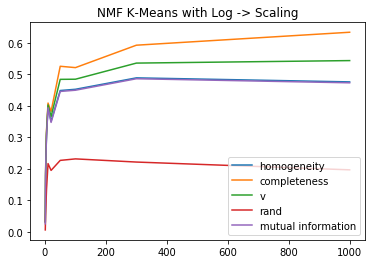

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0303 0.1786 0.2372 0.3077 0.3972 0.3509 0.4489 0.4527 0.4891 0.4763]
Completeness: [0.0334 0.1867 0.2496 0.3224 0.4089 0.3824 0.5259 0.5216 0.5929 0.6341]
V-measure: [0.0318 0.1826 0.2432 0.3149 0.403  0.366  0.4843 0.4847 0.536  0.544 ]
Adjusted Rand Index: [0.0056 0.0533 0.0802 0.1339 0.2164 0.1948 0.2267 0.2315 0.2214 0.1966]
Adjusted Mutual Information Score: [0.0249 0.1741 0.233  0.3039 0.394  0.3474 0.4458 0.4498 0.4862 0.4733]
-------------------------------------------------------------------


In [92]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_log)
plt.plot(r20, nmf_completeness_log)
plt.plot(r20, nmf_v_log)
plt.plot(r20, nmf_rand_log)
plt.plot(r20, nmf_mutual_info_log)

plt.title('NMF K-Means with Log -> Scaling')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [93]:
# svd_log_r20_best = r20[np.argmax(svd_rand_log)]
# print('best r20 svd:', svd_log_r20_best)
# nmf_log_r20_best = r20[np.argmax(nmf_rand_log)]
# print('best r20 nmf:', nmf_log_r20_best)
svd_best_r_log_uv = show_best('svd log', svd_rand_log)
nmf_best_r_log_uv = show_best('nmf log', nmf_rand_log)

best svd log: 10
best nmf log: 100


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3866
Completeness: 0.395
V-measure: 0.3908
Adjusted Rand Index: 0.2264
Adjusted Mutual Information Score: 0.3833
-------------------------------------------------------------------


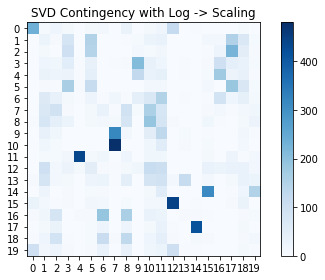

In [94]:
svd_log_transform20 = logarithm_trans(X_data_svd_r20)
svd_log_scaling_transform20 = scaling(svd_log_transform20)
svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_log_scaling_transform20[:, 0:svd_best_r_log_uv])

scores(category_labels, svd_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='SVD Contingency with Log -> Scaling')

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3891
Completeness: 0.4372
V-measure: 0.4118
Adjusted Rand Index: 0.2071
Adjusted Mutual Information Score: 0.3857
-------------------------------------------------------------------


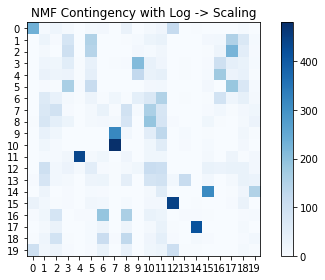

In [95]:
nmf = NMF(n_components=nmf_best_r_log_uv)
X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
nmf_log_transform20 = logarithm_trans(X_data_nmf_r20)
nmf_log_scaling_transform20 = scaling(nmf_log_transform20)
nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_log_scaling_transform20)

scores(category_labels, nmf_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='NMF Contingency with Log -> Scaling')

##### Perform  Scaling -> Log Transform and attain new graphs

In [96]:
# Perform SVD

svd_scaling_transform20 = scaling(X_data_svd_r20)
svd_uv_log_transform20 = logarithm_trans(svd_scaling_transform20)

svd_homogeneity_log = np.zeros(len(r20))
svd_completeness_log = np.zeros(len(r20))
svd_v_log = np.zeros(len(r20))
svd_rand_log = np.zeros(len(r20))
svd_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'svd20_uv_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_log_transform20[:, 0:r20[i]])
        svd_homogeneity_log[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
        svd_completeness_log[i] = completeness_score(category_labels, svd_kmeans.labels_)
        svd_v_log[i] = v_measure_score(category_labels, svd_kmeans.labels_)
        svd_rand_log[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
        svd_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': svd_homogeneity_log,
        'completeness': svd_completeness_log,
        'v': svd_v_log,
        'rand': svd_rand_log,
        'mutual_info': svd_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    svd_homogeneity_log = data['homogeneity']
    svd_completeness_log = data['completeness']
    svd_v_log = data['v']
    svd_rand_log = data['rand']
    svd_mutual_info_log = data['mutual_info']

print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class SVD search: 0.00 minutes


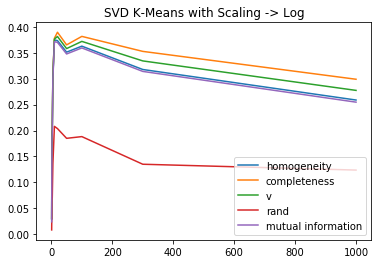

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0291 0.1899 0.2009 0.3036 0.3749 0.3736 0.3513 0.3629 0.3178 0.2589]
Completeness: [0.0306 0.1964 0.2048 0.309  0.3782 0.3897 0.3653 0.3817 0.3528 0.299 ]
V-measure: [0.0298 0.1931 0.2029 0.3063 0.3765 0.3815 0.3582 0.372  0.3344 0.2775]
Adjusted Rand Index: [0.0082 0.0671 0.0708 0.136  0.2081 0.2038 0.185  0.1883 0.135  0.1237]
Adjusted Mutual Information Score: [0.0238 0.1855 0.1966 0.2998 0.3715 0.3702 0.3478 0.3594 0.3141 0.2548]
-------------------------------------------------------------------


In [97]:
# Plot metrics for svd.

plt.figure()
plt.plot(r20, svd_homogeneity_log)
plt.plot(r20, svd_completeness_log)
plt.plot(r20, svd_v_log)
plt.plot(r20, svd_rand_log)
plt.plot(r20, svd_mutual_info_log)

plt.title('SVD K-Means with Scaling -> Log')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [98]:
# Perform NMF

nmf_homogeneity_log = np.zeros(len(r20))
nmf_completeness_log = np.zeros(len(r20))
nmf_v_log = np.zeros(len(r20))
nmf_rand_log = np.zeros(len(r20))
nmf_mutual_info_log = np.zeros(len(r20))

import time
start_time = time.time()

npz_name = 'nmf20_uv_log'

data = load_scores(npz_name)
if data is None:
    for i in range(len(r20)):
        interm_time = time.time()
        nmf = NMF(n_components=r20[i])
        X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
        nmf_scaling_transform20 = scaling(X_data_nmf_r20)
        nmf_uv_log_transform20 = logarithm_trans(nmf_scaling_transform20)
        nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_log_transform20)
        nmf_homogeneity_log[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
        nmf_completeness_log[i] = completeness_score(category_labels, nmf_kmeans.labels_)
        nmf_v_log[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
        nmf_rand_log[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
        nmf_mutual_info_log[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
        print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - interm_time)/60))
    data = {
        'homogeneity': nmf_homogeneity_log,
        'completeness': nmf_completeness_log,
        'v': nmf_v_log,
        'rand': nmf_rand_log,
        'mutual_info': nmf_mutual_info_log
    }
    save_scores(npz_name, data)
else:
    nmf_homogeneity_log = data['homogeneity']
    nmf_completeness_log = data['completeness']
    nmf_v_log = data['v']
    nmf_rand_log = data['rand']
    nmf_mutual_info_log = data['mutual_info']
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

Time taken for kmean 20-class NMF search: 0.00 minutes


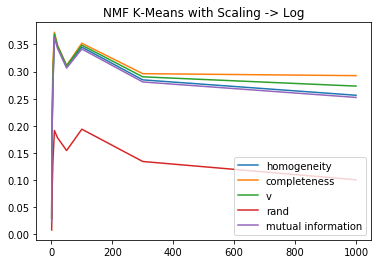

kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: [0.0291 0.1613 0.2128 0.2743 0.3664 0.3465 0.3102 0.3452 0.2848 0.2564]
Completeness: [0.0306 0.1772 0.231  0.3127 0.3725 0.3489 0.3111 0.3523 0.2962 0.2925]
V-measure: [0.0298 0.1689 0.2215 0.2922 0.3694 0.3477 0.3106 0.3487 0.2904 0.2733]
Adjusted Rand Index: [0.0082 0.0642 0.0912 0.1327 0.1915 0.1782 0.1545 0.1939 0.1343 0.1006]
Adjusted Mutual Information Score: [0.0238 0.1568 0.2086 0.2704 0.363  0.343  0.3064 0.3416 0.2809 0.2524]
-------------------------------------------------------------------


In [99]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r20, nmf_homogeneity_log)
plt.plot(r20, nmf_completeness_log)
plt.plot(r20, nmf_v_log)
plt.plot(r20, nmf_rand_log)
plt.plot(r20, nmf_mutual_info_log)

plt.title('NMF K-Means with Scaling -> Log')
plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

scores(category_labels, None, data)

In [100]:
svd_best_r_uv_log = r20[np.argmax(svd_rand_log)]
print('best r20 svd:', svd_log_r20_best)
nmf_best_r_uv_log = r20[np.argmax(nmf_rand_log)]
print('best r20 nmf:', nmf_log_r20_best)

best r20 svd: 10
best r20 nmf: 20


##### Contingency matrices of best SVD and NMF

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3749
Completeness: 0.3782
V-measure: 0.3765
Adjusted Rand Index: 0.2081
Adjusted Mutual Information Score: 0.3715
-------------------------------------------------------------------


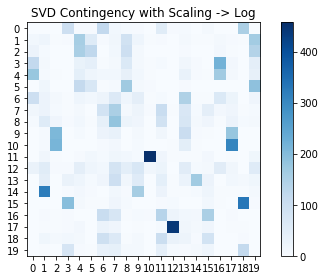

In [101]:
svd_scaling_transform20 = scaling(X_data_svd_r20)
svd_uv_log_transform20 = logarithm_trans(svd_scaling_transform20)
svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(svd_uv_log_transform20[:, 0:svd_best_r_uv_log])

scores(category_labels, svd_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='SVD Contingency with Scaling -> Log')

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.3856
Completeness: 0.3911
V-measure: 0.3883
Adjusted Rand Index: 0.2385
Adjusted Mutual Information Score: 0.3822
-------------------------------------------------------------------


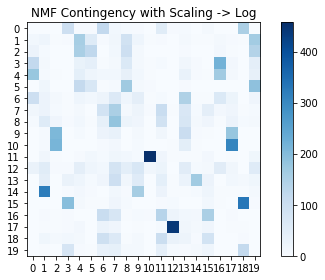

In [102]:
nmf = NMF(n_components=nmf_best_r_uv_log)
X_data_nmf_r20 = nmf.fit_transform(X_data_tfidf20)
nmf_scaling_transform20 = scaling(X_data_nmf_r20)
nmf_uv_log_transform20 = logarithm_trans(nmf_scaling_transform20)
nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=40, n_jobs=-1).fit(nmf_uv_log_transform20)

scores(category_labels, nmf_kmeans)
show_contingency(category_labels, svd_kmeans.labels_, title='NMF Contingency with Scaling -> Log')